# Assignment Two:  Sentiment Classification

I didn't use the code "for classifier in ['svm', '<classifier-2-name>', '<classifier-3-name>']:..." cause how I evaluate is slightly different. But they are very easy to understand. I still use the evaluation code provided. Sorry for not use that code structure.

#### Import necessary packages
You may import more packages here.

In [ ]:
!pip install -q tensorflow
!pip install -q torchtext
!pip install -q emoji
!pip install -q scikit-learn
!pip install -q "transformers[torch]"
!pip install -q sentencepiece
!pip install -U imbalanced-learn scikit-learn


In [ ]:
#!/Users/chenfan/anaconda3/bin/python -m pip install -q tensorflow
#!pip install -q torchtext
#!/Users/chenfan/anaconda3/bin/python -m pip install -q emoji
#!/Users/chenfan/anaconda3/bin/python -m pip install -q scikit-learn
#!/Users/chenfan/anaconda3/bin/python -m pip install -q "transformers[torch]"
#!pip install "transformers[torch]"
#!/Users/chenfan/anaconda3/bin/python -m pip install -q sentencepiece


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 421.5/421.5 kB 3.1 MB/s eta 0:00:00


In [ ]:
# Import necessary packages
import emoji
import tensorflow as tf
import torchtext
import re
from os.path import join
from torch.utils.data import DataLoader
from torchtext.data import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from torch.utils.data import DataLoader
from torchtext.data.functional import to_map_style_dataset
from gensim.models import KeyedVectors
from sklearn.svm import SVC
from sklearn.metrics import f1_score, confusion_matrix, classification_report
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import GridSearchCV
from transformers import BertTokenizer
from transformers import BertModel
from transformers import Trainer
import matplotlib.pyplot as plt
import requests
# Set the device to perform the computation
DEVICE = torch.device('cpu')

# Set a fixed seed for reproducibility
def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
setup_seed(42)

# find the best precessing data method
using only first 10 tweets


In [ ]:
import re
# Define a mapping for traditional emoticons
emoticon_mapping = {
    ":)": "happy_emoticon",
    ":(": "sad_emoticon",
    ":-)": "happy_emoticon",
    ":-(": "sad_emoticon",
    ";-)": "wink_emoticon",
    ";)": "wink_emoticon",
    ":-D": "laughing_emoticon",
    ":D": "laughing_emoticon",
    ":-|": "neutral_emoticon"
}

# Function to replace emoticons with words
def replace_emoticons(text, mapping):
    for emoticon, replacement in mapping.items():
        text = text.replace(emoticon, replacement)
    return text


In [ ]:
#try regex on first 10 tweets
def preprocess_tweet_text(tweet):
    # Translate emojis to text
    tweet = emoji.demojize(tweet, delimiters=(" ", " "))
    # Replace traditional emoticons with words
    tweet = replace_emoticons(tweet, emoticon_mapping)
    # remove URLs
    tweet = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', tweet)
    # remove @
    tweet = re.sub(r'@\w+', '', tweet)
    # remove '#' and keep the text after it
    tweet = re.sub(r'#(?=\w+)', '', tweet)
    # remove extra spaces
    tweet = re.sub(r'\s+', ' ', tweet).strip()
    #convert to lowercase
    tweet = tweet.lower()
    return tweet

In [ ]:
# define the first 10 tweets from the training data to apply regex for preprocessing
example_tweets = [
    "Felt privileged to play Foo Fighters songs on guitar today with one of the plectrums from the gig on Saturday.",
    "@AaqibAfzaal Pakistan may be an Islamic country, but der are a lot true Muslims in India who love their country and can sacrifice all for it",
    "Happy Birthday to the coolest golfer in Bali! @tjvictoriacnd !! :) may you become cooler and cooler everyday! Stay humble little sister! Xx",
    "@SimpplyA TMILLS is going to Tucson! But the 29th and it's on a Thursday :(",
    "Hmmmmm where are the #BlackLivesMatter when matters like this a rise... kids are a disgrace!! https://t.co/aPrB0VtvCN",
    "@Hypable all good, I'm excited about a 3rd season finding home on Netflix. Just want to make sure the readers have the news as it develops",
    "I told my mom I wanted to stay in a hotel for my 18th with people, but my birthdays on Valentine's :-)) lucky me",
    "1st thing I did after baggage claim was get up to date with @RonnaAndBeverly. Bad Blood Ronna &amp; Bev style makes being home a bit more okay",
    "Bobby Jindal wants you to assimilate to heritage of the old confederacy even though his parents are from January dot dot dot",
    "@coolcat1304 I watched it 4 the 1st time & :-).  Voted 4 it in the NTA awards - best Factual program. Mite need 2 watch rest on itvplayer",

]

# Apply the regex preprocessing function to each example tweet
preprocessed_tweets = [preprocess_tweet_text(tweet) for tweet in example_tweets]

preprocessed_tweets

['felt privileged to play foo fighters songs on guitar today with one of the plectrums from the gig on saturday.',
 'pakistan may be an islamic country, but der are a lot true muslims in india who love their country and can sacrifice all for it',
 'happy birthday to the coolest golfer in bali! !! happy_emoticon may you become cooler and cooler everyday! stay humble little sister! xx',
 "tmills is going to tucson! but the 29th and it's on a thursday sad_emoticon",
 'hmmmmm where are the blacklivesmatter when matters like this a rise... kids are a disgrace!!',
 "all good, i'm excited about a 3rd season finding home on netflix. just want to make sure the readers have the news as it develops",
 "i told my mom i wanted to stay in a hotel for my 18th with people, but my birthdays on valentine's happy_emoticon) lucky me",
 '1st thing i did after baggage claim was get up to date with . bad blood ronna &amp; bev style makes being home a bit more okay',
 'bobby jindal wants you to assimilate to 

# Try the whole dataset

#### Load training set, dev set and testing set
Here, you need to load the training set, the development set and the test set. For better classification results, you may need to preprocess tweets before sending them to the classifiers.

In [ ]:
import os
import requests

def download_file_from_google_drive(url, destination):
    if not os.path.exists(destination):
        session = requests.Session()

        response = session.get(url, stream=True)
        token = get_confirm_token(response)

        if token:
            params = {'confirm': token}
            response = session.get(url, params=params, stream=True)

        save_response_content(response, destination)
        print(f"Download complete: {destination}")
    else:
        print(f"File already exists: {destination}")

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value
    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk:  # Filter out keep-alive new chunks
                f.write(chunk)

# Example of corrected URLs
dataset_urls = {
    'training_data': ('https://drive.google.com/uc?export=download&id=1i-S_le3x9jt7RXePar-_b50VK1qzykfU', 'training_data.txt'),
    'dev_data': ('https://drive.google.com/uc?export=download&id=1BgGjlc_LflwsJ47eHz5thdixDD7YqwwT', 'dev_data.txt'),
    'test1_data': ('https://drive.google.com/uc?export=download&id=1mvvssQvJfipDs5yHZbdwYzIJcqCVnJCi', 'test1_data.txt'),
    'test2_data': ('https://drive.google.com/uc?export=download&id=1y0N7BmHmDILKGyWeLo0jQ_QLc1M3tavH', 'test2_data.txt'),
    'test3_data': ('https://drive.google.com/uc?export=download&id=1t0w4Tr9AFkpEqswSqs6e0iNbFeNx9mAk', 'test3_data.txt'),
    # Please add file here.
    #'test4_data': ('the url for test 4, or local path', 'test4_data.txt'),
    #'test5_data': ('the url for test 5, or local path', 'test5_data.txt'),

}
# Initialize dictionaries to hold the data
data = {}
tweetids = {}
tweetgts = {}
tweets = {}

# Download each dataset if not already present, then load
for name, (url, local_filename) in dataset_urls.items():
    download_file_from_google_drive(url, local_filename)

    # Load the dataset from the local file
    dataset = pd.read_csv(local_filename, header=None, sep="\t", names=["tweetid", "tweetgt", "tweet"], dtype={'tweetid': str})

    # Store the loaded data in the respective dictionaries
    data[name] = dataset
    tweetids[name] = dataset["tweetid"].tolist()
    tweetgts[name] = dataset["tweetgt"].tolist()
    tweets[name] = dataset["tweet"].tolist()

print(len(data['training_data']))
print(len(data['dev_data']))
print(len(data['test1_data']))
print(len(data['test2_data']))
print(len(data['test3_data']))

Download complete: training_data.txt
Download complete: dev_data.txt
Download complete: test1_data.txt
Download complete: test2_data.txt
Download complete: test3_data.txt
45026
2000
3531
1853
2379


In [ ]:
import re
import numpy as np
import nltk
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize


# Preprocess the tweet
def preprocess_tweet(tweet):
    # Translate emojis to text
    tweet = emoji.demojize(tweet, delimiters=(" ", " "))
    # Replace traditional emoticons with words
    tweet = replace_emoticons(tweet, emoticon_mapping)
    # Remove URLs
    tweet = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', tweet)
    # Remove @mentions
    tweet = re.sub(r'@\w+', '', tweet)
    # Remove '#' but keep the text
    tweet = re.sub(r'#', '', tweet)
    # Remove extra spaces
    tweet = re.sub(r'\s+', ' ', tweet).strip()
    # Convert to lowercase
    tweet = tweet.lower()
    # Lemmatize text
    tweet = lemmatize_text(tweet)
    return tweet

# Lemmatization
lemmatizer = WordNetLemmatizer()

def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

def lemmatize_text(text):
    tokens = word_tokenize(text)
    tagged = nltk.pos_tag(tokens)
    lemmatized_sentence = [lemmatizer.lemmatize(word, get_wordnet_pos(tag)) for word, tag in tagged]
    return ' '.join(lemmatized_sentence)


def preprocess_and_tokenize_tweet(tweet, tokenizer):
    preprocessed_tweet = preprocess_tweet(tweet)
    sequence = tokenizer.texts_to_sequences([preprocessed_tweet])
    return sequence[0]


# Download the glove.6B.100d. If already downloaded, you can change the path here.

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

def load_glove_embeddings(glove_dir):
    embeddings_index = {}
    with open(f'{glove_dir}/glove.6B.100d.txt', 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    print(f'Found {len(embeddings_index)} word vectors.')
    return embeddings_index

all_tweets = []
for name in tweets.keys():
    all_tweets.extend(tweets[name])

def initialize_and_fit_tokenizer(all_tweets, max_words=10000):
    tokenizer = Tokenizer(num_words=max_words)
    tokenizer.fit_on_texts(all_tweets)
    return tokenizer

def convert_to_sequences_and_pad(tokenizer, tweets, max_sequence_length=30):
    sequences = tokenizer.texts_to_sequences(tweets)
    padded = pad_sequences(sequences, maxlen=max_sequence_length)
    return padded

In [ ]:
# Initialize and fit the tokenizer
tokenizer = initialize_and_fit_tokenizer(all_tweets)
max_words = 10000

# Convert tweets to sequences and pad them
# these are for neutral net work train and test
max_sequence_length = 30
X_train_seq = convert_to_sequences_and_pad(tokenizer, data['training_data']['tweet'], max_sequence_length)
X_dev_seq = convert_to_sequences_and_pad(tokenizer, data['dev_data']['tweet'], max_sequence_length)
X_test1_seq = convert_to_sequences_and_pad(tokenizer, data['test1_data']['tweet'], max_sequence_length)
X_test2_seq = convert_to_sequences_and_pad(tokenizer, data['test2_data']['tweet'], max_sequence_length)
X_test3_seq = convert_to_sequences_and_pad(tokenizer, data['test3_data']['tweet'], max_sequence_length)

## If you don't mind, you can just use this code to process test4,5

#X_test4_seq = convert_to_sequences_and_pad(tokenizer, data['test4_data']['tweet'], max_sequence_length)
#X_test5_seq = convert_to_sequences_and_pad(tokenizer, data['test5_data']['tweet'], max_sequence_length)


In [ ]:
print(X_train_seq[:2])

[[   0    0    0    0    0    0    0    0    0    0    0 2290 8758    2
   154  423  393  838    8 3177   78   15   57   10    1   40    1 1938
     8   59]
 [   0    0    0    0    0 2114   21   16   76 3047  615   26 6479   35
     6  474  431  324    5 1258   88   98  143  615    7   62 6939   37
    11   18]]


# Use glove file's path. Here I save it on my local environment. You can change it accoring to you.

In [ ]:
def load_glove_embeddings(glove_dir, embedding_dim=100):
    embeddings_index = {}
    with open(f'{glove_dir}/glove.6B.{embedding_dim}d.txt', 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    print(f'Found {len(embeddings_index)} word vectors.')
    return embeddings_index

glove_dir = 'glove.6B'
embedding_dim = 100

# Load the GloVe embeddings
embeddings_index = load_glove_embeddings(glove_dir, embedding_dim)

# create the embedding matrix
word_index = tokenizer.word_index
num_words = min(max_words, len(word_index) + 1)
embedding_matrix = np.zeros((num_words, embedding_dim))
for word, i in word_index.items():
    if i >= max_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector


Found 400000 word vectors.


# Term Frequency-Inverse Document Frequency

I choose to use TF-IDF for further feature extraction in traditional machine learning models like SVM and Decision Trees.
SVM and Decision Trees can struggle with very high-dimensional data. TF-IDF helps by transforming the text data into a more manageable form, where each document is represented by a vector in a lower-dimensional space.
Also, after using TF-IDF,features fed into SVMs and Decision Trees are numeric and reflect the significance of each term in the documents. This can lead to better model performance.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

def preprocess_and_vectorize(dataframe, tokenizer, tfidf_vectorizer=None, fit_vectorizer=False):
    # Preprocess tweets and join tokens
    dataframe['preprocessed_tweet'] = dataframe['tweet'].apply(lambda x: ' '.join(map(str, preprocess_and_tokenize_tweet(x, tokenizer))))

    if fit_vectorizer:
        # Fit the TF-IDF Vectorizer on the combined corpus if specified
        tfidf_vectorizer.fit(dataframe['preprocessed_tweet'])

    # Transform the preprocessed tweets to TF-IDF features
    features_tfidf = tfidf_vectorizer.transform(dataframe['preprocessed_tweet'])

    return features_tfidf

# Initialize the TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Preprocess tweets and vectorize (fit the vectorizer on the training data)
X_train_tfidf = preprocess_and_vectorize(data['training_data'], tokenizer, tfidf_vectorizer, fit_vectorizer=True)
X_dev_tfidf = preprocess_and_vectorize(data['dev_data'], tokenizer, tfidf_vectorizer)
X_test1_tfidf = preprocess_and_vectorize(data['test1_data'], tokenizer, tfidf_vectorizer)
X_test2_tfidf = preprocess_and_vectorize(data['test2_data'], tokenizer, tfidf_vectorizer)
X_test3_tfidf = preprocess_and_vectorize(data['test3_data'], tokenizer, tfidf_vectorizer)
# If you don't mind, you can just use this code to process test4,5

#X_test4_tfidf = preprocess_and_vectorize(data['test4_data'], tokenizer, tfidf_vectorizer)
#X_test5_tfidf = preprocess_and_vectorize(data['test5_data'], tokenizer, tfidf_vectorizer)


In [ ]:
label_encoder = LabelEncoder()
labels = ["positive", "negative", "neutral"]
label_encoder.fit(labels)
label_mapping = { 0: 'negative', 1: 'neutral',2: 'positive',}

y_train = label_encoder.transform(data['training_data']['tweetgt'].tolist())
y_dev = label_encoder.transform(data['dev_data']['tweetgt'].tolist())
y_test1 = label_encoder.transform(data['test1_data']['tweetgt'].tolist())
y_test2 = label_encoder.transform(data['test2_data']['tweetgt'].tolist())
y_test3 = label_encoder.transform(data['test3_data']['tweetgt'].tolist())

# If you don't mind, you can just use this code to process test4,5
#y_test4 = label_encoder.transform(data['test4_data']['tweetgt'].tolist())
#y_test5 = label_encoder.transform(data['test5_data']['tweetgt'].tolist())


In [ ]:
from collections import Counter

# Assuming y_train is your training labels dataset
class_counts = Counter(y_train)
print("y train:" ,class_counts)
class_counts = Counter(y_dev)
print("y dev:" ,class_counts)
class_counts = Counter(y_test1)
print("y test1:" ,class_counts)
class_counts = Counter(y_test2)
print("y test2:" ,class_counts)
class_counts = Counter(y_test3)
print("y test3:" ,class_counts)

y train: Counter({1: 20749, 2: 15960, 0: 8317})
y dev: Counter({1: 919, 2: 703, 0: 378})
y test1: Counter({1: 1504, 2: 1470, 0: 557})
y test2: Counter({2: 982, 1: 669, 0: 202})
y test3: Counter({2: 1033, 1: 983, 0: 363})


From the result, I see some dataset is not balanced between 3 classed. So I use balanced weight in svm and decision tree.

The reason for choosing 30 as the max_sequence_length is the code below. After calcuation, 95% tweets' length is 26. So choose the number 30 would be both time saving and appropriate.

In [ ]:
# find a suitable max_sequence_length
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words=10000)

all_tweets = []
all_tweets = tweets['training_data'] + tweets['dev_data']+ tweets['test1_data'] + tweets['test1_data']+tweets['test3_data']

# Fit the tokenizer on the collected tweets
tokenizer.fit_on_texts(all_tweets)

# convert all tweets to sequences
all_sequences = tokenizer.texts_to_sequences(all_tweets)

# Calculate the length of each sequence
sequence_lengths = [len(seq) for seq in all_sequences]

# Analyze the distribution of sequence lengths
print(f"Median sequence length: {np.median(sequence_lengths)}")
percentile_95 = np.percentile(sequence_lengths, 95)
percentile_80 = np.percentile(sequence_lengths, 80)
print(f"95th percentile of sequence lengths: {percentile_95}")
print(f"80th percentile of sequence lengths: {percentile_80}")

Median sequence length: 19.0
95th percentile of sequence lengths: 26.0
80th percentile of sequence lengths: 23.0


In [ ]:
# examples to see how is the processing steps
for tweet in X_train_tfidf[:1]:
    print(tweet)


  (0, 6400)	0.2015210919237093
  (0, 5799)	0.40870674472377017
  (0, 4682)	0.19631053042010796
  (0, 4509)	0.18755210649260054
  (0, 3187)	0.27396467105382083
  (0, 2973)	0.17683110814130693
  (0, 2195)	0.3844347670001529
  (0, 2138)	0.26807272950035566
  (0, 1905)	0.2516443305494883
  (0, 1318)	0.3661759470294715
  (0, 966)	0.34709083248285755
  (0, 567)	0.2097572087750656
  (0, 528)	0.1316381724747396
  (0, 0)	0.11596135042041388


In [ ]:
for tweet in X_train_seq[:2]:
    print(tweet)

[   0    0    0    0    0    0    0    0    0    0    0 2290 8758    2
  154  423  393  838    8 3177   78   15   57   10    1   40    1 1938
    8   59]
[   0    0    0    0    0 2114   21   16   76 3047  615   26 6479   35
    6  474  431  324    5 1258   88   98  143  615    7   62 6939   37
   11   18]


# I change the name for function evaluation to evaluate_prediction cause there is a conflict in using evaluate in LSTM.

In [ ]:
# Skeleton: Evaluation code for the test sets
def read_test(testset):
    id_gts = {}
    with open(testset, 'r', encoding='utf8') as fh:
        for line in fh:
            fields = line.split('\t')
            tweetid = fields[0]
            gt = fields[1]

            id_gts[tweetid] = gt

    return id_gts

def confusion(id_preds, testset, classifier):
    id_gts = read_test(testset)

    gts = []
    for m, c1 in id_gts.items():
        if c1 not in gts:
            gts.append(c1)

    gts = ['positive', 'negative', 'neutral']

    conf = {}
    for c1 in gts:
        conf[c1] = {}
        for c2 in gts:
            conf[c1][c2] = 0

    for tweetid, gt in id_gts.items():
        if tweetid in id_preds:
            pred = id_preds[tweetid]
        else:
            pred = 'neutral'
        conf[pred][gt] += 1

    print(''.ljust(12) + '  '.join(gts))

    for c1 in gts:
        print(c1.ljust(12), end='')
        for c2 in gts:
            if sum(conf[c1].values()) > 0:
                print('%.3f     ' % (conf[c1][c2] / float(sum(conf[c1].values()))), end='')
            else:
                print('0.000     ', end='')
        print('')

    print('')


def evaluate_prediction(id_preds, testset, classifier):
    id_gts = read_test(testset)

    acc_by_class = {}
    for gt in ['positive', 'negative', 'neutral']:
        acc_by_class[gt] = {'tp': 0, 'fp': 0, 'tn': 0, 'fn': 0}

    catf1s = {}

    ok = 0
    not_found_ids = []  # List to store tweet IDs not found in id_preds
    found_ids_count = 0
    for tweetid, gt in id_gts.items():
        if tweetid in id_preds:
            pred = id_preds[tweetid]
            found_ids_count += 1  # Increment found IDs counter
        else:
            pred = 'neutral'
            not_found_ids.append(tweetid)  # Add the not found tweetid to the list
        if gt == pred:
            ok += 1
            acc_by_class[gt]['tp'] += 1
        else:
            acc_by_class[gt]['fn'] += 1
            acc_by_class[pred]['fp'] += 1
    print(f"Found IDs: {found_ids_count}")
    print(f"Not Found IDs: {len(not_found_ids)}")
    catcount = 0
    itemcount = 0
    macro = {'p': 0, 'r': 0, 'f1': 0}
    micro = {'p': 0, 'r': 0, 'f1': 0}
    semevalmacro = {'p': 0, 'r': 0, 'f1': 0}

    microtp = 0
    microfp = 0
    microtn = 0
    microfn = 0
    for cat, acc in acc_by_class.items():
        catcount += 1

        microtp += acc['tp']
        microfp += acc['fp']
        microtn += acc['tn']
        microfn += acc['fn']

        p = 0
        if (acc['tp'] + acc['fp']) > 0:
            p = float(acc['tp']) / (acc['tp'] + acc['fp'])

        r = 0
        if (acc['tp'] + acc['fn']) > 0:
            r = float(acc['tp']) / (acc['tp'] + acc['fn'])

        f1 = 0
        if (p + r) > 0:
            f1 = 2 * p * r / (p + r)

        catf1s[cat] = f1

        n = acc['tp'] + acc['fn']

        macro['p'] += p
        macro['r'] += r
        macro['f1'] += f1

        if cat in ['positive', 'negative']:
            semevalmacro['p'] += p
            semevalmacro['r'] += r
            semevalmacro['f1'] += f1

        itemcount += n

    micro['p'] = float(microtp) / float(microtp + microfp)
    micro['r'] = float(microtp) / float(microtp + microfn)
    micro['f1'] = 2 * float(micro['p']) * micro['r'] / float(micro['p'] + micro['r'])

    semevalmacrof1 = semevalmacro['f1'] / 2

    print(testset + ' (' + classifier + '): %.3f' % semevalmacrof1)

# SVM
# Stochastic Gradient Descent + balance weight(to avoid the influence from imbalanced data)

In [ ]:
import numpy as np
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import ParameterGrid
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

svm_model = SGDClassifier(class_weight='balanced',loss='hinge', penalty='l2', alpha=1e-3, random_state=42, max_iter=1000, tol=1e-3)

# Train the SVM model
y_train = data['training_data']['tweetgt']
y_dev = data['dev_data']['tweetgt']
svm_model.fit(X_train_tfidf, y_train)

def predict_and_evaluate(X_tfidf, dataframe, testset_path, classifier):
    # Predict using the SVM model
    y_pred = svm_model.predict(X_tfidf)

    # Create id_preds: a dictionary mapping tweet IDs to predicted labels (strings)
    predicted_labels = y_pred
    tweet_ids = dataframe['tweetid'].tolist()
    id_preds = dict(zip(tweet_ids, predicted_labels))

    features = 'TF-IDF'
    classifier = 'SVM'
    evaluate_prediction(id_preds, testset_path, classifier)
    confusion(id_preds, testset_path, classifier)

    y_true = data['dev_data']['tweetgt'].tolist()
    accuracy = accuracy_score(y_true, y_pred)
    print(f"Accuracy: {accuracy}")
    return id_preds

id_preds = predict_and_evaluate(X_dev_tfidf, data['dev_data'], 'twitter-dev-data.txt', 'SVM')

twitter-dev-data.txt (SVM): 0.646
            positive  negative  neutral
positive    0.634     0.056     0.311     
negative    0.089     0.525     0.385     
neutral     0.220     0.078     0.702     

Accuracy: 0.627


# The accuracy is modest. I try to improve it by tuning parameters. ( Don't have to run code below, you can just see the best result.)


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
import pandas as pd
from sklearn.metrics import make_scorer, average_precision_score
param_grid = {
    'alpha': [1e-4, 1e-3, 1e-2],
    'loss': ['hinge'],
    'penalty': ['l2', 'l1', 'elasticnet'],
}

# Initialize the SGDClassifier
sgd = SGDClassifier(loss='log', class_weight='balanced', random_state=42, max_iter=1000, tol=1e-3)

# Initialize the GridSearchCV object with 5-fold cross-validation
grid_search = GridSearchCV(sgd, param_grid, scoring='roc_auc_ovo', cv=5, verbose=1)

# Fit the grid search to the data
grid_search.fit(X_train_tfidf, y_train)

# Print the best parameters and the best score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

# Optionally, evaluate on the development set
best_model = grid_search.best_estimator_
y_dev_pred = best_model.predict(X_dev_tfidf)
dev_accuracy = accuracy_score(y_dev, y_dev_pred)
print("Development Set Accuracy:", dev_accuracy)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best Parameters: {'alpha': 0.0001, 'loss': 'hinge', 'penalty': 'elasticnet'}
Best Score: 0.6278372749957676
Development Set Accuracy: 0.6385


# use 3 test set to test the best parameters

In [ ]:
# Define the test sets for evaluation
test_sets = [
    ('test1_data','test1_data.txt', X_test1_tfidf, y_test1),
    ('test2_data','test2_data.txt', X_test2_tfidf, y_test2),
    ('test3_data','test3_data.txt', X_test3_tfidf, y_test3)
]


In [ ]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score
# Best parameters obtained from GridSearchCV
best_params = {'alpha': 0.0001, 'loss': 'hinge', 'penalty': 'elasticnet'}

# Initialize the SGDClassifier with the best parameters
best_sgd_model = SGDClassifier(**best_params, random_state=42)

# Fit the model on the training data
best_sgd_model.fit(X_train_tfidf, y_train)

for test_name,testset_path, X_test, y_test in test_sets:
    y_pred = best_sgd_model.predict(X_test)
    predicted_labels = y_pred
    tweet_ids = data[test_name]['tweetid'].tolist()
    id_preds = dict(zip(tweet_ids, predicted_labels))

    features = 'TF-IDF'
    classifier = 'SVM'

    evaluate_prediction(id_preds, testset_path, classifier)
    confusion(id_preds, testset_path, classifier)

    y_true = data[test_name]['tweetgt'].tolist()
    accuracy = accuracy_score(y_true, y_pred)
    print(f"Accuracy: {accuracy}")
    print('------------------------------------')


test1_data.txt (SVM): 0.492
            positive  negative  neutral
positive    0.790     0.056     0.154     
negative    0.138     0.826     0.036     
neutral     0.266     0.164     0.570     

Accuracy: 0.6451430189747946
------------------------------------
test2_data.txt (SVM): 0.513
            positive  negative  neutral
positive    0.833     0.051     0.116     
negative    0.115     0.827     0.058     
neutral     0.362     0.112     0.527     

Accuracy: 0.6492174851592013
------------------------------------
test3_data.txt (SVM): 0.455
            positive  negative  neutral
positive    0.785     0.081     0.134     
negative    0.167     0.750     0.083     
neutral     0.316     0.145     0.539     

Accuracy: 0.6128625472887768
------------------------------------


This SVM model directly predict the class labels that were used during training. These predictions are in the same format as the y_train labels. Cause I redefined y_train = data['training_data']['tweetgt'], so the labels are not integers, but positive,negative and neutral.So no need for reverse mapping here.

# Decision tree

In [ ]:
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

# Initialize the Decision Tree model
dt_model = DecisionTreeClassifier(random_state=42, class_weight='balanced')

# Train the Decision Tree model
y_train = data['training_data']['tweetgt']
y_dev = data['dev_data']['tweetgt']
dt_model.fit(X_train_tfidf, y_train)

def dt_predict_and_evaluate(X_tfidf, dataframe, testset_path, classifier):
    # Predict using the Decision Tree model
    y_pred = dt_model.predict(X_tfidf)

    predicted_labels = y_pred
    tweet_ids = dataframe['tweetid'].tolist()
    id_preds = dict(zip(tweet_ids, predicted_labels))

    features = 'TF-IDF'
    classifier = 'Decision Tree'
    evaluate_prediction(id_preds, testset_path, classifier)
    confusion(id_preds, testset_path, classifier)

    y_true = data['dev_data']['tweetgt'].tolist()
    accuracy = accuracy_score(y_true, y_pred)
    print(f"Accuracy: {accuracy}")
    return id_preds


id_preds_dt = dt_predict_and_evaluate(X_dev_tfidf, data['dev_data'], 'twitter-dev-data.txt', 'Decision Tree')


twitter-dev-data.txt (Decision Tree): 0.471
            positive  negative  neutral
positive    0.520     0.108     0.372     
negative    0.216     0.398     0.386     
neutral     0.279     0.154     0.567     

Accuracy: 0.5145


# Also try to use different parameters to improve

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
import pandas as pd
from sklearn.metrics import make_scorer, accuracy_score

param_grid = {
    'max_depth': [None, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 4],
}

# Initialize the DecisionTreeClassifier
dt = DecisionTreeClassifier(random_state=42)

# Initialize the GridSearchCV object with 5-fold cross-validation
grid_search = GridSearchCV(dt, param_grid, scoring='accuracy', cv=5, verbose=1)

# Fit the grid search to the data
grid_search.fit(X_train_tfidf, y_train)

# Print the best parameters and the best score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

# evaluate on the development set
best_model = grid_search.best_estimator_
y_dev_pred = best_model.predict(X_dev_tfidf)
dev_accuracy = accuracy_score(y_dev, y_dev_pred)
print("Development Set Accuracy:", dev_accuracy)


Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best Parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5}
Best Score: 0.5429086784391872
Development Set Accuracy: 0.5445


test on 3 test data

In [ ]:
test_sets = [
    ('test1_data','test1_data.txt', X_test1_tfidf, y_test1),
    ('test2_data','test2_data.txt', X_test2_tfidf, y_test2),
    ('test3_data','test3_data.txt', X_test3_tfidf, y_test3)
]

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# Best parameters obtained from GridSearchCV for DecisionTreeClassifier
best_params_dt = {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'class_weight': 'balanced'}

# Initialize the DecisionTreeClassifier with the best parameters
best_dt_model = DecisionTreeClassifier(**best_params_dt, random_state=42)

# Fit the model on the training data
best_dt_model.fit(X_train_tfidf, y_train)

for test_name,testset_path, X_test, y_test in test_sets:
    # Predict using the best Decision Tree model
    y_pred = best_dt_model.predict(X_test)
    predicted_labels =  y_pred

    tweet_ids = data[test_name]['tweetid'].tolist()
    id_preds = dict(zip(tweet_ids, predicted_labels))

    features = 'TF-IDF'
    classifier = 'Decision Tree'
    evaluate_prediction(id_preds, testset_path, classifier)
    confusion(id_preds, testset_path, classifier)

    print("-------------------------------------")


test1_data.txt (Decision Tree): 0.413
            positive  negative  neutral
positive    0.612     0.096     0.291     
negative    0.363     0.247     0.390     
neutral     0.315     0.142     0.543     

-------------------------------------
test2_data.txt (Decision Tree): 0.390
            positive  negative  neutral
positive    0.712     0.076     0.212     
negative    0.423     0.174     0.403     
neutral     0.459     0.093     0.448     

-------------------------------------
test3_data.txt (Decision Tree): 0.399
            positive  negative  neutral
positive    0.665     0.104     0.231     
negative    0.371     0.229     0.399     
neutral     0.347     0.122     0.531     

-------------------------------------


Just like with the SVM model, when using a Decision Tree Classifier , there is also no need for reverse mapping of the predictions to evaluate the model's performance.

# LSTM

# I use imbalanced-learn package.
Because the number of negative labels is far less than neutral.

# Don't run this two code cell, it takes too long. The best hyperparameters I found already written below this cell.

In [ ]:
#!/Users/chenfan/anaconda3/bin/python -m pip install -q wandb
!pip install -q wandb
import wandb
wandb.login()

wandb: Currently logged in as: chenfan7108. Use `wandb login --relogin` to force relogin


True

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import wandb


class CustomDataset(Dataset):
    def __init__(self, X, y):
        X = np.stack(X)
        self.X = torch.tensor(X, dtype=torch.long).squeeze(1)
        self.y = torch.tensor(y, dtype=torch.long)


    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, embedding_matrix, dropout_rate):
        super(LSTMClassifier, self).__init__()
        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim)
        self.embedding.weight = nn.Parameter(embedding_matrix, requires_grad=False)
        self.lstm = nn.LSTM(input_size=embedding_dim, hidden_size=hidden_dim, num_layers=3, dropout=dropout_rate, batch_first=True)
        self.dropout = nn.Dropout(dropout_rate)
        self.classifier = nn.Linear(hidden_dim, output_dim)

    def forward(self, text):
        embedded = self.embedding(text)
        lstm_out, (hidden, _) = self.lstm(embedded)
        hidden = self.dropout(hidden[-1])
        output = self.classifier(hidden)
        return output
def train():
    wandb.init()
    config = wandb.config

    train_dataset = CustomDataset(X_train, y_train)
    val_dataset = CustomDataset(X_test, y_test)

    train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=config.batch_size, shuffle=False)

    model = LSTMClassifier(
        vocab_size=5001,
        embedding_dim=100,
        hidden_dim=256,
        output_dim=3,
        embedding_matrix=torch.FloatTensor(embedding_matrix),
        dropout_rate=config.dropout
    ).to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=config.learning_rate, weight_decay=config.regularization)

    for epoch in range(config.epochs):
        model.train()
        train_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)

        train_loss /= len(train_loader.dataset)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)

        val_loss /= len(val_loader.dataset)

        wandb.log({"train_loss": train_loss, "val_loss": val_loss})

    wandb.finish()

sweep_config = {
    'method': 'bayes',
    'metric': {'name': 'val_loss', 'goal': 'minimize'},
    'parameters': {
        'dropout': {'values': [0.2, 0.3, 0.4, 0.5]},
        'learning_rate': {'values': [1e-2, 1e-3, 1e-4]},
        'batch_size': {'values': [16, 32, 64, 128]},
        'regularization': {'values': [0, 1e-4, 1e-3]},
        'epochs': {'values': [5, 10, 20]}
    }
}

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the sweep
sweep_id = wandb.sweep(sweep_config, project="lstm_hyperparameter_tuning", entity="chenfan7108")

# Start the sweep
wandb.agent(sweep_id, train)


Create sweep with ID: 7f9mxkui
Sweep URL: https://wandb.ai/chenfan7108/lstm_hyperparameter_tuning/sweeps/7f9mxkui


wandb: Agent Starting Run: o5j4ymw6 with config:
wandb: 	batch_size: 32
wandb: 	dropout: 0.4
wandb: 	epochs: 10
wandb: 	learning_rate: 0.0001
wandb: 	regularization: 0.001


train_loss,█▄▃▃▂▂▂▁▁▁
val_loss,█▅▅▄▄▃▂▂▁▁
train_loss,0.81702
val_loss,0.80106


wandb: Agent Starting Run: gtu10uzg with config:
wandb: 	batch_size: 16
wandb: 	dropout: 0.5
wandb: 	epochs: 5
wandb: 	learning_rate: 0.01
wandb: 	regularization: 0.0001


train_loss,▁▂█▆▆
val_loss,█▄▁▁▇
train_loss,1.09753
val_loss,1.10858


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: wcexk782 with config:
wandb: 	batch_size: 16
wandb: 	dropout: 0.3
wandb: 	epochs: 5
wandb: 	learning_rate: 0.0001
wandb: 	regularization: 0


train_loss,█▄▃▂▁
val_loss,██▃▂▁
train_loss,0.7832
val_loss,0.7659


wandb: Agent Starting Run: 3qztuwgh with config:
wandb: 	batch_size: 32
wandb: 	dropout: 0.3
wandb: 	epochs: 10
wandb: 	learning_rate: 0.0001
wandb: 	regularization: 0


train_loss,█▅▄▄▃▂▂▂▁▁
val_loss,█▇▄▄▃▃▂▂▁▁
train_loss,0.75032
val_loss,0.75393


wandb: Agent Starting Run: urc5fvt2 with config:
wandb: 	batch_size: 32
wandb: 	dropout: 0.3
wandb: 	epochs: 10
wandb: 	learning_rate: 0.0001
wandb: 	regularization: 0


train_loss,█▅▄▃▃▂▂▂▁▁
val_loss,█▄▄▃▂▂▁▂▁▁
train_loss,0.75202
val_loss,0.7601


wandb: Agent Starting Run: op0gi8ty with config:
wandb: 	batch_size: 64
wandb: 	dropout: 0.3
wandb: 	epochs: 5
wandb: 	learning_rate: 0.0001
wandb: 	regularization: 0


train_loss,█▄▃▂▁
val_loss,█▄▃▂▁
train_loss,0.80728
val_loss,0.7901


wandb: Agent Starting Run: murabrj9 with config:
wandb: 	batch_size: 32
wandb: 	dropout: 0.2
wandb: 	epochs: 10
wandb: 	learning_rate: 0.0001
wandb: 	regularization: 0.0001


train_loss,█▅▄▃▃▂▂▂▁▁
val_loss,█▆▄▆▃▂▂▃▃▁
train_loss,0.76248
val_loss,0.76026


wandb: Agent Starting Run: c9xvnry2 with config:
wandb: 	batch_size: 64
wandb: 	dropout: 0.2
wandb: 	epochs: 10
wandb: 	learning_rate: 0.0001
wandb: 	regularization: 0


train_loss,█▅▄▃▃▂▂▂▁▁
val_loss,█▆▄▃▃▂▃▁▁▂
train_loss,0.76631
val_loss,0.78126


wandb: Agent Starting Run: eajbltev with config:
wandb: 	batch_size: 16
wandb: 	dropout: 0.2
wandb: 	epochs: 20
wandb: 	learning_rate: 0.0001
wandb: 	regularization: 0.0001


train_loss,█▆▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▂▁▁
val_loss,█▆▆▅▄▄▃▃▂▂▃▂▂▂▁▂▁▂▁▂
train_loss,0.6789
val_loss,0.74526


wandb: Agent Starting Run: hlpyg6cy with config:
wandb: 	batch_size: 16
wandb: 	dropout: 0.2
wandb: 	epochs: 20
wandb: 	learning_rate: 0.0001
wandb: 	regularization: 0.0001


train_loss,█▆▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▁▁
val_loss,█▆▅▄▅▃▃▃▂▂▂▂▂▁▁▂▂▁▃▂
train_loss,0.67623
val_loss,0.75203


wandb: Agent Starting Run: u1xsh36h with config:
wandb: 	batch_size: 32
wandb: 	dropout: 0.2
wandb: 	epochs: 10
wandb: 	learning_rate: 0.0001
wandb: 	regularization: 0


train_loss,█▅▄▄▃▃▂▂▁▁
val_loss,█▆▅▄▄▃▃▂▁▂
train_loss,0.74943
val_loss,0.7695


wandb: Agent Starting Run: w5pj6jbz with config:
wandb: 	batch_size: 32
wandb: 	dropout: 0.2
wandb: 	epochs: 5
wandb: 	learning_rate: 0.0001
wandb: 	regularization: 0


train_loss,█▄▃▂▁
val_loss,█▅▂▂▁
train_loss,0.79508
val_loss,0.78654


wandb: Agent Starting Run: zr3o9927 with config:
wandb: 	batch_size: 128
wandb: 	dropout: 0.2
wandb: 	epochs: 20
wandb: 	learning_rate: 0.0001
wandb: 	regularization: 0.001


train_loss,█▄▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
val_loss,█▅▄▄▃▃▃▃▃▃▃▂▂▂▁▁▁▁▁▁
train_loss,0.80409
val_loss,0.79664


wandb: Agent Starting Run: qfjgozi2 with config:
wandb: 	batch_size: 16
wandb: 	dropout: 0.2
wandb: 	epochs: 20
wandb: 	learning_rate: 0.0001
wandb: 	regularization: 0


train_loss,█▆▆▆▅▅▅▅▄▄▄▄▃▃▃▂▂▂▁▁
val_loss,█▅▄▃▂▂▃▂▁▄▁▁▁▂▂▃▃▃▄▆
train_loss,0.59211
val_loss,0.82259


wandb: Agent Starting Run: un9lfp4w with config:
wandb: 	batch_size: 16
wandb: 	dropout: 0.3
wandb: 	epochs: 20
wandb: 	learning_rate: 0.0001
wandb: 	regularization: 0.001


train_loss,█▅▄▄▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁
val_loss,█▄▄▄▃▃▄▂▂▂▂▂▂▂▂▁▁▁▁▁
train_loss,0.78628
val_loss,0.77823


wandb: Agent Starting Run: b0f59xf1 with config:
wandb: 	batch_size: 16
wandb: 	dropout: 0.2
wandb: 	epochs: 10
wandb: 	learning_rate: 0.0001
wandb: 	regularization: 0.001


train_loss,█▄▃▃▂▂▂▁▁▁
val_loss,█▇▅▃▄▄▂▁▂▁
train_loss,0.80967
val_loss,0.79858


wandb: Agent Starting Run: sbavq85n with config:
wandb: 	batch_size: 32
wandb: 	dropout: 0.2
wandb: 	epochs: 20
wandb: 	learning_rate: 0.0001
wandb: 	regularization: 0.001


train_loss,█▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁
val_loss,█▇▅▄▄▄▃▃▆▃▃▂▂▂▂▂▁▂▁▁
train_loss,0.7891
val_loss,0.78188


wandb: Agent Starting Run: 5bahyu0o with config:
wandb: 	batch_size: 128
wandb: 	dropout: 0.4
wandb: 	epochs: 20
wandb: 	learning_rate: 0.0001
wandb: 	regularization: 0.001


train_loss,█▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
val_loss,█▅▅▄▃▃▃▃▂▂▃▂▂▂▂▂▂▃▂▁
train_loss,0.80369
val_loss,0.79137


wandb: Agent Starting Run: z7hw4wdn with config:
wandb: 	batch_size: 32
wandb: 	dropout: 0.3
wandb: 	epochs: 20
wandb: 	learning_rate: 0.0001
wandb: 	regularization: 0.001


train_loss,█▅▄▄▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁
val_loss,█▆▅▅▄▄▄▃▄▃▃▃▂▂▂▂▂▂▂▁
train_loss,0.79316
val_loss,0.77756


wandb: Agent Starting Run: ojy9jvdq with config:
wandb: 	batch_size: 128
wandb: 	dropout: 0.4
wandb: 	epochs: 20
wandb: 	learning_rate: 0.0001
wandb: 	regularization: 0


train_loss,█▅▅▄▄▄▃▃▃▃▂▂▂▂▂▂▁▁▁▁
val_loss,█▆▅▄▄▃▄▃▂▂▂▂▂▂▂▁▁▁▂▁
train_loss,0.73928
val_loss,0.75057


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: vao3lu20 with config:
wandb: 	batch_size: 128
wandb: 	dropout: 0.5
wandb: 	epochs: 10
wandb: 	learning_rate: 0.0001
wandb: 	regularization: 0


train_loss,█▅▄▃▂▂▂▂▁▁
val_loss,█▆▅▄▃▂▃▂▂▁
train_loss,0.791
val_loss,0.77485


wandb: Agent Starting Run: 02f900yf with config:
wandb: 	batch_size: 128
wandb: 	dropout: 0.4
wandb: 	epochs: 20
wandb: 	learning_rate: 0.0001
wandb: 	regularization: 0


train_loss,█▅▅▄▄▄▃▃▃▃▂▂▂▂▂▂▁▁▁▁
val_loss,█▆▅▅▄▄▃▃▃▃▂▂▂▁▁▁▁▁▁▁
train_loss,0.73731
val_loss,0.74966


wandb: Agent Starting Run: 7tqph6pj with config:
wandb: 	batch_size: 64
wandb: 	dropout: 0.5
wandb: 	epochs: 20
wandb: 	learning_rate: 0.0001
wandb: 	regularization: 0.0001


train_loss,█▆▅▄▄▄▃▃▃▃▂▂▂▂▂▂▁▁▁▁
val_loss,█▆▅▄▄▄▄▃▄▃▂▄▃▂▂▂▂▂▂▁
train_loss,0.73573
val_loss,0.73815


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 1lp3dap5 with config:
wandb: 	batch_size: 32
wandb: 	dropout: 0.5
wandb: 	epochs: 20
wandb: 	learning_rate: 0.0001
wandb: 	regularization: 0.0001


train_loss,█▆▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁
val_loss,█▆▅▄▄▄▃▃▃▄▃▂▂▂▁▁▃▁▁▁
train_loss,0.72015
val_loss,0.74665


wandb: Agent Starting Run: o6rf96iu with config:
wandb: 	batch_size: 128
wandb: 	dropout: 0.2
wandb: 	epochs: 20
wandb: 	learning_rate: 0.01
wandb: 	regularization: 0.0001


# best hypeparamters: batch size=64, drop out=0.5, epoch=10, learning rate=0.0001,regularization=0.0001

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

class CustomDataset(Dataset):
    def __init__(self, sequences, labels):
        self.X = sequences
        self.y = labels
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        sequence = torch.tensor(self.X[idx], dtype=torch.long)
        label = torch.tensor(self.y[idx], dtype=torch.long)
        return sequence, label

class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, embedding_matrix, dropout_rate):
        super(LSTMClassifier, self).__init__()
        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim)
        self.embedding.weight = nn.Parameter(embedding_matrix, requires_grad=False)
        self.lstm = nn.LSTM(input_size=embedding_dim, hidden_size=hidden_dim, num_layers=3, dropout=dropout_rate, batch_first=True)
        self.dropout = nn.Dropout(dropout_rate)
        self.classifier = nn.Linear(hidden_dim, output_dim)
    def forward(self, text):
        embedded = self.embedding(text)
        lstm_out, (hidden, _) = self.lstm(embedded)
        hidden = self.dropout(hidden[-1])
        output = self.classifier(hidden)
        return output


In [ ]:
from sklearn.utils.class_weight import compute_class_weight

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights_tensor = torch.FloatTensor(class_weights).to(device)

# The training process for lstm model takes 10 minutes. I saved the file if you want to skip the training process. You can do whatever you want.

Epoch 1/10 - Train Loss: 0.9650, Validation Loss: 0.8890, Validation Accuracy: 0.5505
Epoch 2/10 - Train Loss: 0.8849, Validation Loss: 0.8621, Validation Accuracy: 0.5910
Epoch 3/10 - Train Loss: 0.8604, Validation Loss: 0.8447, Validation Accuracy: 0.5670
Epoch 4/10 - Train Loss: 0.8467, Validation Loss: 0.8306, Validation Accuracy: 0.5680
Epoch 5/10 - Train Loss: 0.8356, Validation Loss: 0.8142, Validation Accuracy: 0.5930
Epoch 6/10 - Train Loss: 0.8289, Validation Loss: 0.8077, Validation Accuracy: 0.5835
Epoch 7/10 - Train Loss: 0.8231, Validation Loss: 0.7997, Validation Accuracy: 0.6040
Epoch 8/10 - Train Loss: 0.8135, Validation Loss: 0.7973, Validation Accuracy: 0.5960
Epoch 9/10 - Train Loss: 0.8094, Validation Loss: 0.7989, Validation Accuracy: 0.6190
Epoch 10/10 - Train Loss: 0.7989, Validation Loss: 0.7925, Validation Accuracy: 0.6060


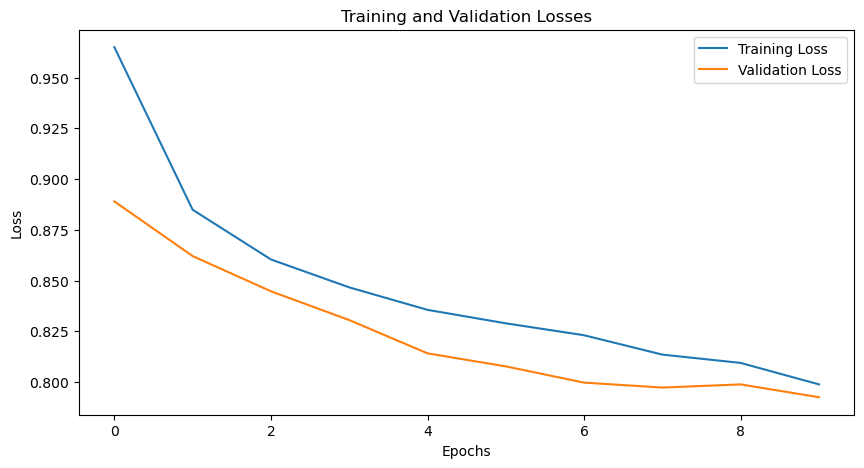

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.utils.class_weight import compute_class_weight

def evaluate(model, data_loader, criterion, device):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():  # Disable gradient calculation
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_predictions += labels.size(0)

    average_loss = total_loss / len(data_loader.dataset)
    accuracy = correct_predictions / total_predictions
    return average_loss, accuracy

def train(vocab_size, embedding_dim, hidden_dim, output_dim, embedding_matrix, learning_rate, dropout_rate, batch_size, regularization, epochs, X_train_seq, y_train, X_test_seq, y_test, device):

    train_dataset = CustomDataset(X_train_seq, y_train)
    val_dataset = CustomDataset(X_test_seq, y_test)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    lstm_model = LSTMClassifier(
        vocab_size=vocab_size,
        embedding_dim=embedding_dim,
        hidden_dim=hidden_dim,
        output_dim=output_dim,
        embedding_matrix=torch.FloatTensor(embedding_matrix),
        dropout_rate=dropout_rate
    ).to(device)

    criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
    optimizer = optim.Adam(lstm_model.parameters(), lr=learning_rate, weight_decay=regularization)

    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        lstm_model.train()
        train_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = lstm_model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)

        train_loss /= len(train_loader.dataset)
        train_losses.append(train_loss)

        val_loss, val_accuracy = evaluate(lstm_model, val_loader, criterion, device)
        val_losses.append(val_loss)
        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Training and Validation Losses')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    return lstm_model

lstm_model =train(
    vocab_size=5001,  embedding_dim=100,  hidden_dim=256,
    output_dim=3,  embedding_matrix=torch.FloatTensor(embedding_matrix),
    learning_rate=0.0001, dropout_rate=0.5, batch_size=64,
    regularization=0.0001, epochs=10,
    X_train_seq=X_train_seq,  y_train=y_train,
    X_test_seq=X_dev_seq, y_test=y_dev,device=DEVICE
)


In [ ]:
# Don't run this.Just save the model.
import torch

model_save_path = "lstm_model.pth"
torch.save(lstm_model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")


Model saved to lstm_model.pth


# Then load the model.
 I use torch.save to save the model not pickle. Cause I tried pickle but mistakes happen. You can just run the code below to download my trained LSTM model. My torch version in 2.2.0

# Load the lstm model.

In [ ]:
import requests

def download_file_from_google_drive(id, destination):
    URL = "https://drive.google.com/uc?export=download"

    session = requests.Session()
    response = session.get(URL, params={'id': id}, stream=True)
    token = get_confirm_token(response)

    if token:
        params = {'id': id, 'confirm': token}
        response = session.get(URL, params=params, stream=True)

    save_response_content(response, destination)

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value
    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)

file_id = '1CYJ9c4a2QlF9S8ko8T20fMVepD1uPfNW'
destination = 'lstm_model.pth'
download_file_from_google_drive(file_id, destination)
print(f"Model downloaded to {destination}")


Model downloaded to lstm_model.pth


In [ ]:
import torch

# Create an instance of the LSTMClassifier with the same parameters used for training
loaded_model = LSTMClassifier(vocab_size=5001, embedding_dim=100, hidden_dim=256, output_dim=3,embedding_matrix=torch.FloatTensor(embedding_matrix),  dropout_rate=0.5)

# Load the model state dictionary
model_path = 'lstm_model.pth'
loaded_model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))

loaded_model.eval()

# Now, the loaded_model is ready to make predictions


LSTMClassifier(
  (embedding): Embedding(5001, 100)
  (lstm): LSTM(100, 256, num_layers=3, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (classifier): Linear(in_features=256, out_features=3, bias=True)
)

# After load the model, use 3 testset to test.

In [ ]:
test_sets = [
    ('test1_data','test1_data.txt', X_test1_seq, y_test1),
    ('test2_data','test2_data.txt', X_test2_seq, y_test2),
    ('test3_data','test3_data.txt', X_test3_seq, y_test3)
    # you can just use this code
    #('test4_data','test4_data.txt', X_test4_seq, y_test4),
    #('test5_data','test4_data.txt', X_test4_seq, y_test5)

]

In [ ]:
def test_lstm_model_on_test_sets(model, test_sets, device):
    model.eval()  # Set the model to evaluation mode
    inverse_label_mapping = {0: 'negative', 1: 'neutral', 2: 'positive'}  # Define the inverse label mapping
    for test_name,testset_path, X_seq, y in test_sets:
        # Prepare the test dataset and DataLoader
        print(f"Processing {test_name}...")
        test_dataset = CustomDataset(X_seq, y)
        test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

        tweet_ids = data[test_name]['tweetid'].tolist()
        # Generate predictions

        pred_labels = []
        with torch.no_grad():
            for inputs, labels in test_loader:

                inputs = inputs.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs, 1)
                pred_labels.extend(predicted.cpu().numpy())

        predicted_labels_str = [inverse_label_mapping[int(label)] for label in pred_labels]

        id_preds_str = dict(zip(tweet_ids, predicted_labels_str))

        features = 'Glove embedding'
        classifier = 'LSTM'
        evaluate_prediction(id_preds_str, testset_path, classifier)
        confusion(id_preds_str, testset_path, classifier)
        print("-------------------------------------")

# Define label_mapping
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
test_lstm_model_on_test_sets(loaded_model, test_sets, DEVICE)

Processing test1_data...
test1_data.txt (LSTM): 0.611
            positive  negative  neutral
positive    0.739     0.048     0.213     
negative    0.258     0.502     0.240     
neutral     0.242     0.096     0.662     

-------------------------------------
Processing test2_data...
test2_data.txt (LSTM): 0.597
            positive  negative  neutral
positive    0.756     0.054     0.190     
negative    0.247     0.447     0.306     
neutral     0.378     0.056     0.566     

-------------------------------------
Processing test3_data...
test3_data.txt (LSTM): 0.569
            positive  negative  neutral
positive    0.748     0.045     0.207     
negative    0.258     0.386     0.356     
neutral     0.301     0.078     0.621     

-------------------------------------


# GRU Gated Recurrent Units

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights_tensor = torch.FloatTensor(class_weights).to(device)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset  # Ensure TensorDataset is imported here
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, classification_report
import matplotlib.pyplot as plt

class CustomDataset(Dataset):
    def __init__(self, sequences, labels):
        self.X = sequences
        self.y = labels

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        sequence = torch.tensor(self.X[idx], dtype=torch.long)
        label = torch.tensor(self.y[idx], dtype=torch.long)
        return sequence, label
class GRUClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, embedding_matrix, dropout_rate):
        super(GRUClassifier, self).__init__()
        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim)
        self.embedding.weight = nn.Parameter(embedding_matrix, requires_grad=False)
        self.gru = nn.GRU(input_size=embedding_dim, hidden_size=hidden_dim, num_layers=3, dropout=dropout_rate, batch_first=True)
        self.dropout = nn.Dropout(dropout_rate)
        self.classifier = nn.Linear(hidden_dim, output_dim)

    def forward(self, text):
        embedded = self.embedding(text)
        gru_out, hidden = self.gru(embedded)
        hidden = self.dropout(hidden[-1])
        output = self.classifier(hidden)
        return output

Epoch 1/10 - Train Loss: 0.9496, Validation Loss: 0.8889, Validation Accuracy: 0.5370
Epoch 2/10 - Train Loss: 0.8717, Validation Loss: 0.8796, Validation Accuracy: 0.5370
Epoch 3/10 - Train Loss: 0.8480, Validation Loss: 0.8388, Validation Accuracy: 0.6040
Epoch 4/10 - Train Loss: 0.8294, Validation Loss: 0.8094, Validation Accuracy: 0.5755
Epoch 5/10 - Train Loss: 0.8158, Validation Loss: 0.8170, Validation Accuracy: 0.6035
Epoch 6/10 - Train Loss: 0.8066, Validation Loss: 0.8096, Validation Accuracy: 0.6175
Epoch 7/10 - Train Loss: 0.7967, Validation Loss: 0.7842, Validation Accuracy: 0.6095
Epoch 8/10 - Train Loss: 0.7888, Validation Loss: 0.8095, Validation Accuracy: 0.6020
Epoch 9/10 - Train Loss: 0.7819, Validation Loss: 0.7753, Validation Accuracy: 0.6280
Epoch 10/10 - Train Loss: 0.7775, Validation Loss: 0.7732, Validation Accuracy: 0.6290


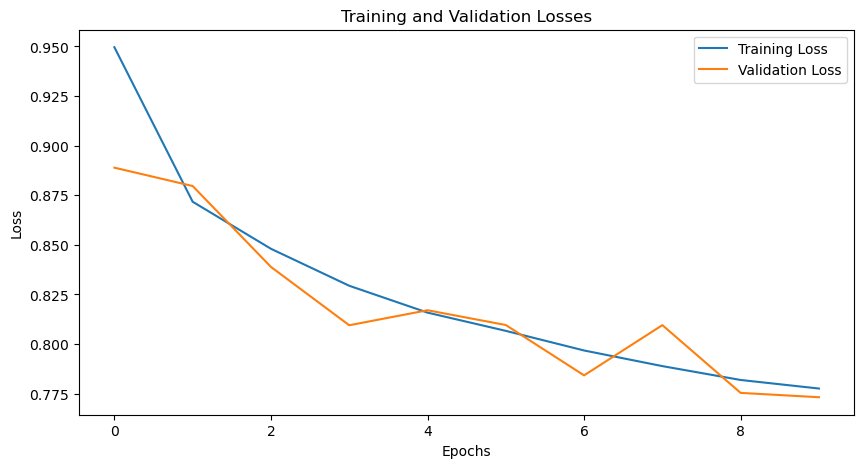

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.utils.class_weight import compute_class_weight

def evaluate(model, data_loader, criterion, device):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():  # Disable gradient calculation
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_predictions += labels.size(0)

    average_loss = total_loss / len(data_loader.dataset)
    accuracy = correct_predictions / total_predictions
    return average_loss, accuracy

def train(vocab_size, embedding_dim, hidden_dim, output_dim, embedding_matrix, learning_rate, dropout_rate, batch_size, regularization, epochs, X_train_seq, y_train, X_test_seq, y_test, device):

    train_dataset = CustomDataset(X_train_seq, y_train)
    val_dataset = CustomDataset(X_test_seq, y_test)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    gru_model = GRUClassifier(
        vocab_size=vocab_size,
        embedding_dim=embedding_dim,
        hidden_dim=hidden_dim,
        output_dim=output_dim,
        embedding_matrix=torch.FloatTensor(embedding_matrix),
        dropout_rate=dropout_rate
    ).to(device)

    criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
    optimizer = optim.Adam(gru_model.parameters(), lr=learning_rate, weight_decay=regularization)

    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        lstm_model.train()
        train_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = gru_model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)

        train_loss /= len(train_loader.dataset)
        train_losses.append(train_loss)

        val_loss, val_accuracy = evaluate(gru_model, val_loader, criterion, device)
        val_losses.append(val_loss)
        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Training and Validation Losses')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    return gru_model

gru_model =train(
    vocab_size=5001,  embedding_dim=100,  hidden_dim=256,
    output_dim=3,  embedding_matrix=torch.FloatTensor(embedding_matrix),
    learning_rate=0.0001, dropout_rate=0.5, batch_size=64,
    regularization=0.0001, epochs=10,
    X_train_seq=X_train_seq,  y_train=y_train,
    X_test_seq=X_dev_seq, y_test=y_dev,device=DEVICE
)


# Still save the gru model.

In [ ]:
import torch

model_save_path = "gru_model.pth"
torch.save(lstm_model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to gru_model.pth


# Download the gru model.

In [ ]:
import requests

def download_file_from_google_drive(id, destination):
    URL = "https://drive.google.com/uc?export=download"

    session = requests.Session()
    response = session.get(URL, params={'id': id}, stream=True)
    token = get_confirm_token(response)

    if token:
        params = {'id': id, 'confirm': token}
        response = session.get(URL, params=params, stream=True)

    save_response_content(response, destination)

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value
    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)

file_id = '12TYpOMcPACKwEBvZ10GzX9wTsJmfLptK'
destination = 'gru_model.pth'
download_file_from_google_drive(file_id, destination)
print(f"Model downloaded to {destination}")


Model downloaded to gru_model.pth


In [ ]:
import torch

# Create an instance of the LSTMClassifier with the same parameters used for training
loaded_gru_model = GRUClassifier(vocab_size=5001, embedding_dim=100, hidden_dim=256, output_dim=3,embedding_matrix=torch.FloatTensor(embedding_matrix),  dropout_rate=0.5)

# Load the model state dictionary
model_path = 'gru_model.pth'
loaded_model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))

loaded_gru_model.eval()

# Now, the loaded_model is ready to make predictions


GRUClassifier(
  (embedding): Embedding(5001, 100)
  (gru): GRU(100, 256, num_layers=3, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (classifier): Linear(in_features=256, out_features=3, bias=True)
)

In [ ]:
def test_gru_model_on_test_sets(model, test_sets, device):
    model.eval()  # Set the model to evaluation mode
    inverse_label_mapping = {0: 'negative', 1: 'neutral', 2: 'positive'}  # Define the inverse label mapping
    for test_name,testset_path, X_seq, y in test_sets:
        # Prepare the test dataset and DataLoader
        print(f"Processing {test_name}...")
        test_dataset = CustomDataset(X_seq, y)
        test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

        tweet_ids = data[test_name]['tweetid'].tolist()
        # Generate predictions

        pred_labels = []
        with torch.no_grad():
            for inputs, labels in test_loader:

                inputs = inputs.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs, 1)
                pred_labels.extend(predicted.cpu().numpy())

        predicted_labels_str = [inverse_label_mapping[int(label)] for label in pred_labels]

        id_preds_str = dict(zip(tweet_ids, predicted_labels_str))

        features = 'Glove embedding'
        classifier = 'GRU'
        evaluate_prediction(id_preds_str, testset_path, classifier)
        confusion(id_preds_str, testset_path, classifier)
        print("-------------------------------------")

# Define label_mapping
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
test_gru_model_on_test_sets(loaded_gru_model, test_sets, DEVICE)

Processing test1_data...
Number of IDs not found: 0
IDs not found: []
test1_data.txt (GRU): 0.397
            positive  negative  neutral
positive    0.400     0.137     0.463     
negative    0.492     0.248     0.260     
neutral     0.375     0.125     0.500     

-------------------------------------
Processing test2_data...
Number of IDs not found: 0
IDs not found: []
test2_data.txt (GRU): 0.441
            positive  negative  neutral
positive    0.522     0.087     0.390     
negative    0.556     0.199     0.245     
neutral     0.611     0.000     0.389     

-------------------------------------
Processing test3_data...
Number of IDs not found: 0
IDs not found: []
test3_data.txt (GRU): 0.407
            positive  negative  neutral
positive    0.430     0.136     0.434     
negative    0.457     0.234     0.308     
neutral     0.346     0.000     0.654     

-------------------------------------


# TinyBERT
- For this model, I run the code on colab cause I need to use the colab pro's computation units to speed up processing.
- I also save the model so that you don't have to run the long traing time. Just follow the instruction I wrote to download the file.

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import Trainer, TrainingArguments
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np

class BertDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        # Modified line to avoid the warning
        item = {key: val[idx].clone().detach() for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

 # Load TinyBERT tokenizer and model
tokenizer = AutoTokenizer.from_pretrained('huawei-noah/TinyBERT_General_4L_312D')
model = AutoModelForSequenceClassification.from_pretrained('huawei-noah/TinyBERT_General_4L_312D', num_labels=3)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/409 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/62.7M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at huawei-noah/TinyBERT_General_4L_312D and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Combine tweets from different datasets into a single list
#all_tweets = tweets['training_data'] + tweets['dev_data'] + tweets['test1_data'] + tweets['test2_data'] + tweets['test3_data']

def bert_encode_tweets(tweets, tokenizer, max_length):
    encoded_dict = tokenizer(
        tweets,                      # List of tweets to encode
        add_special_tokens=True,     # Add '[CLS]' and '[SEP]'
        padding='max_length',        # Pad to `max_length`
        truncation=True,             # Truncate to `max_length`
        max_length=max_length,       # Specify the max length
        return_tensors='pt',         # Return PyTorch tensors
        return_attention_mask=True   # Return attention masks
    )
    return input_ids, attention_masks

label_encoder = LabelEncoder()
label_encoder.fit(["negative", "neutral", "positive"])  # Fit encoder to all possible labels
labels = ["positive", "negative","neutral"]
encoded_labels = label_encoder.transform(labels)

#preprocessed_tweets = [preprocess_tweet(tweet) for tweet in all_tweets]
#input_ids, attention_masks = bert_encode_tweets(preprocessed_tweets, tokenizer, max_length)

max_length = 23  # to reduce training time

In [ ]:
# If run the code in colab, maybe need this.
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
def preprocess_and_tokenize(data_tweets, tokenizer, max_length, device):
    preprocessed_tweets = [preprocess_tweet(tweet) for tweet in data_tweets]

    # Tokenize all tweets at once
    encoded_batch = tokenizer(preprocessed_tweets, padding=True, truncation=True,
                              max_length=max_length, return_tensors="pt")

    # Move encoded batch to the specified device (GPU/TPU)
    encoded_batch = {k: v.to(device) for k, v in encoded_batch.items()}

    return encoded_batch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
max_length = 23  # Adjust based on your dataset requirements

x_train_bert = preprocess_and_tokenize(data['training_data']['tweet'], tokenizer, max_length, device)
x_dev_bert = preprocess_and_tokenize(data['dev_data']['tweet'], tokenizer, max_length, device)
x_test1_bert = preprocess_and_tokenize(data['test1_data']['tweet'], tokenizer, max_length, device)
x_test2_bert = preprocess_and_tokenize(data['test2_data']['tweet'], tokenizer, max_length, device)
x_test3_bert = preprocess_and_tokenize(data['test3_data']['tweet'], tokenizer, max_length, device)
#x_test4_bert = preprocess_and_tokenize(data['test4_data']['tweet'], tokenizer, max_length, device)
#x_test5_bert = preprocess_and_tokenize(data['test4_data']['tweet'], tokenizer, max_length, device)


I use this stucture to speed up processing.

In [ ]:
import torch
from torch.utils.data import DataLoader
from transformers import AdamW
from sklearn.metrics import accuracy_score

def train_and_evaluate(model, train_loader, val_loader, device, epochs=2, accumulation_steps=4):
    model.to(device)
    optimizer = AdamW(model.parameters(), lr=1e-4)

    # Training loop
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for step, batch in enumerate(train_loader):
            batch = {k: v.to(device) for k, v in batch.items()}

            outputs = model(**batch)
            loss = outputs.loss / accumulation_steps
            loss.backward()

            if (step + 1) % accumulation_steps == 0:
                optimizer.step()
                optimizer.zero_grad()

            total_loss += loss.item()

        # Print training loss
        print(f"Epoch {epoch+1}/{epochs}, Training Loss: {total_loss / len(train_loader)}")

        # Evaluation loop
        model.eval()
        predictions, true_labels = [], []
        with torch.no_grad():
            for batch in val_loader:
                batch = {k: v.to(device) for k, v in batch.items()}

                outputs = model(**batch)
                logits = outputs.logits
                preds = torch.argmax(logits, dim=-1).detach().cpu().numpy()
                labels = batch['labels'].detach().cpu().numpy()

                predictions.extend(preds)
                true_labels.extend(labels)

        # Calculate accuracy
        val_acc = accuracy_score(true_labels, predictions)
        print(f"Epoch {epoch+1}/{epochs}, Validation Accuracy: {val_acc}")



In [ ]:
# Print the keys of the dictionary
print("Keys of x_train_bert:", x_train_bert.keys())

# Print the first few lines of input_ids and attention_mask tensors
print("First few lines of input_ids tensor:", x_train_bert['input_ids'][:5])
print("First few lines of attention_mask tensor:", x_train_bert['attention_mask'][:5])


Keys of x_train_bert: dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])
First few lines of input_ids tensor: tensor([[  101,  2371, 14293,  2000,  2377, 29379,  4959,  2299,  2006,  2858,
          2651,  2007,  2028,  1997,  1996, 20228, 22471,  6824,  2013,  1996,
         15453,  2006,   102],
        [  101,  4501,  2089,  2022,  2019,  5499,  2406,  1010,  2021,  4315,
          2022,  1037,  2843,  2995,  5152,  1999,  2634,  2040,  2293,  2037,
          2406,  1998,   102],
        [  101,  3407,  5798,  2000,  1996,  4658, 20601,  1999, 20222,   999,
           999,   999,  3407,  1035,  7861, 20214,  2239,  2089,  2017,  2468,
         14976,  1998,   102],
        [  101,  1056, 19912,  2015,  2022,  2175,  2000, 17478,   999,  2021,
          1996, 16318,  1998,  2009,  1005,  1055,  2006,  1037,  9432,  6517,
          1035,  7861,   102],
        [  101, 17012,  7382,  2213,  2073,  2022,  1996,  2304,  3669,  6961,
         18900,  3334,  2043,  3043,  2066,  

In [ ]:
train_dataset = BertDataset(x_train_bert, y_train)
val_dataset = BertDataset(x_dev_bert, y_dev)
batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_and_evaluate(model, train_loader, val_loader, device, epochs=2)


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/2, Training Loss: 0.19702505718910038
Epoch 1/2, Validation Accuracy: 0.672
Epoch 2/2, Training Loss: 0.16832644225066762
Epoch 2/2, Validation Accuracy: 0.6745


In [ ]:
# save the file, don't run this code

model_save_path = "/content/drive/My Drive/CS918/tinybert_model.pth"
# Save the model's state dictionary
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")


Model saved to /content/drive/My Drive/CS918/tinybert_model.pth


In [ ]:
#  run this code and load  saved tinybert model file
import torch
from transformers import AutoModelForSequenceClassification
import requests

def download_file_from_google_drive(id, destination):
    URL = "https://drive.google.com/uc?export=download"

    session = requests.Session()
    response = session.get(URL, params={'id': id}, stream=True)
    token = get_confirm_token(response)

    if token:
        params = {'id': id, 'confirm': token}
        response = session.get(URL, params=params, stream=True)

    save_response_content(response, destination)

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value
    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)

file_id = '1EiJDGJH8kTVEzY0aLLCIsOyrtLJ3G6Vg'
destination = 'tinybert_model.pth'
download_file_from_google_drive(file_id, destination)
print(f"Model downloaded to {destination}")


# model is now ready to make predictions


Model downloaded to tinybert_model.pth


In [ ]:
test_sets = [
    ('test1_data', 'test1_data.txt', x_test1_bert, y_test1),
    ('test2_data', 'test2_data.txt', x_test2_bert, y_test2),
    ('test3_data', 'test3_data.txt', x_test3_bert, y_test3),
   # ('test4_data', 'test4_data.txt', x_test4_bert, y_test4),
   # ('test5_data', 'test5_data.txt', x_test5_bert, y_test5),
]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
def test_tinybert_model_on_test_sets(model, test_sets, tokenizer, device):
    model.eval()  # Set the model to evaluation mode

    for test_name, testset_path, x_bert, labels in test_sets:
        # Prepare the test dataset and DataLoader
        print(f"Processing {test_name}...")
        test_dataset = BertDataset(encodings=x_bert, labels=labels)
        test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

        tweet_ids = data[test_name]['tweetid'].tolist()

        pred_labels = []
        with torch.no_grad():
            for batch in test_loader:
                inputs = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                outputs = model(input_ids=inputs, attention_mask=attention_mask)
                _, predicted = torch.max(outputs.logits, dim=1)
                pred_labels.extend(predicted.cpu().numpy())

        inverse_label_mapping = {0: 'negative', 1: 'neutral', 2: 'positive'}
        predicted_labels = [inverse_label_mapping[int(label)]  for label in pred_labels]

        features = 'BERT Embeddings'
        classifier = 'TinyBERT'
        id_preds = dict(zip(tweet_ids, predicted_labels))
        evaluate_prediction(id_preds, testset_path, classifier)
        confusion(id_preds, testset_path, classifier)
        print("-------------------------------------")

        DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

test_tinybert_model_on_test_sets(model, test_sets, tokenizer, device)

Processing test1_data...
Found IDs: 3531
Not Found IDs: 0
test1_data.txt (TinyBERT): 0.646
            positive  negative  neutral
positive    0.730     0.034     0.237     
negative    0.137     0.677     0.186     
neutral     0.238     0.127     0.635     

-------------------------------------
Processing test2_data...
Found IDs: 1853
Not Found IDs: 0
test2_data.txt (TinyBERT): 0.636
            positive  negative  neutral
positive    0.777     0.038     0.185     
negative    0.161     0.613     0.226     
neutral     0.328     0.090     0.581     

-------------------------------------
Processing test3_data...
Found IDs: 2379
Not Found IDs: 0
test3_data.txt (TinyBERT): 0.614
            positive  negative  neutral
positive    0.772     0.041     0.187     
negative    0.172     0.521     0.307     
neutral     0.277     0.111     0.612     

-------------------------------------
